# GF-KSD: Failure Modes (Figure 2)

In [1]:
import torch
import torch.distributions as D
from torch.distributions import MultivariateNormal, Normal

from scipy.stats.qmc import Sobol
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("seaborn-white")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['text.usetex'] = False

from pylab import rcParams
rcParams['figure.figsize'] = 10,6

from matplotlib import cm

from steintorch.utils.get_score import get_score
from steintorch.utils.cdf import get_1D_mixture_cdf, get_icdf
from steintorch.distribution.base import Distribution

### $P_1$

In [2]:
weights = torch.Tensor([0.6,0.9,0.1])
mean_vec = torch.Tensor([[-0.4],[0.3],[0.06]])
var_vec = torch.Tensor([[0.2],[0.2],[0.9]])

mix = D.Categorical(weights)
normal = D.Normal(mean_vec, var_vec)
comp = D.Independent(normal, 1)
p_1 = D.MixtureSameFamily(mix, comp)
p_1.cdf = get_1D_mixture_cdf(normal,weights)  # make the target P have a well defined CDF

q_1 = torch.distributions.Normal(torch.Tensor([0]), torch.Tensor([1.5]))
score_q_1 = lambda sample: get_score(sample, q_1)


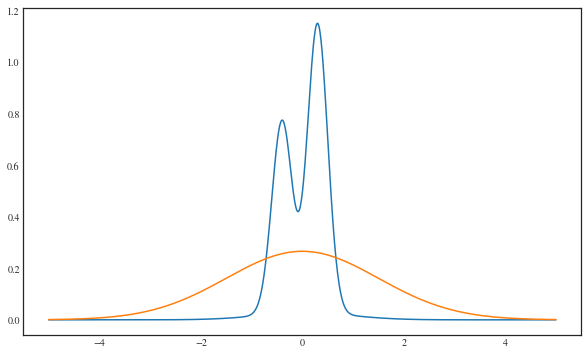

In [3]:
xx = torch.linspace(-5,5,1000).unsqueeze(1)
plt.plot(xx, p_1.log_prob(xx).exp())
plt.plot(xx, q_1.log_prob(xx).exp())
plt.show()

### $P_2$

In [4]:
p_2 = D.Normal(torch.Tensor([0]), torch.Tensor([1]))
q_2 = D.Normal(torch.Tensor([-0.7]), torch.Tensor([0.1]))
score_q_2 = lambda sample: get_score(sample, q_2)

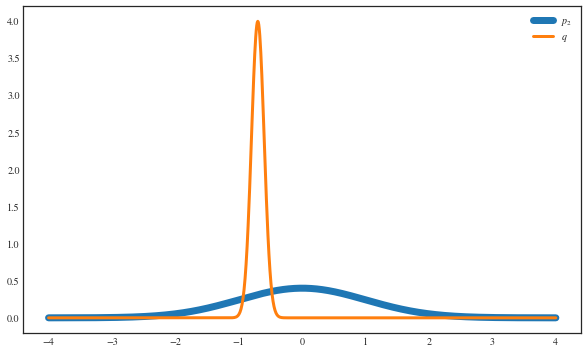

In [5]:

xx = torch.linspace(-4,4,1000).unsqueeze(1)
plt.plot(xx, p_2.log_prob(xx).exp(), label='$p_2$', linewidth=7)
plt.plot(xx, q_2.log_prob(xx).exp(), label='$q$', linewidth=3)
plt.legend()
plt.show()

### $P_3$

In [9]:
p_3_1d = Normal(torch.Tensor([0]), torch.Tensor([1]))
p_3_10d = MultivariateNormal(torch.zeros(10), torch.eye(10))
p_3_100d = MultivariateNormal(torch.zeros(100), torch.eye(100))

q_3_1d = Normal(torch.Tensor([0]), torch.Tensor([1]) * 1.1)
q_3_10d = MultivariateNormal(torch.zeros(10), torch.eye(10) * 1.1)
q_3_100d = MultivariateNormal(torch.zeros(100), torch.eye(100) * 1.1)

score_q_3_1d = lambda sample: get_score(sample, q_3_1d)
score_q_3_10d = lambda sample: get_score(sample, q_3_10d)
score_q_3_100d = lambda sample: get_score(sample, q_3_100d)

uniform_mesh_p3_1 = p_3_1d

In [7]:
def get_uniform_sequence(x, u = torch.Tensor([0,1])):
    location, scale = u
    standard_normal = Normal(torch.Tensor([0]), torch.Tensor([1]))
    mesh = standard_normal.icdf(x) 
    mesh.T[0] = mesh.T[0] * scale + location
    return mesh


/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


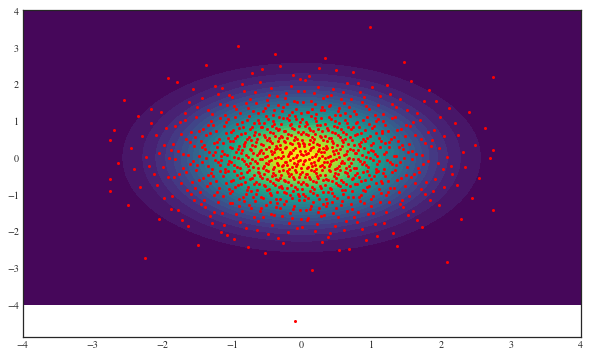

In [8]:
p_3_2d = MultivariateNormal(torch.zeros(2), torch.eye(2) * 1)

x_2D = torch.linspace(-4,4,100)   
y_2D = torch.linspace(-4,4,100)

X_2D,Y_2D = torch.meshgrid(x_2D,y_2D)

meshs = torch.stack([X_2D,Y_2D]).T.reshape(X_2D.shape[0]**2,2)
Ztrue = p_3_2d.log_prob(meshs).exp()

sobols_2D = torch.Tensor(Sobol(2).random_base2(10))
sobols_2D.T[0] = sobols_2D.T[0].clamp(0.003, 0.997)

mixture_samps = get_uniform_sequence(sobols_2D)

plt.contourf(X_2D.numpy(),Y_2D.numpy(), Ztrue.reshape(100,100).T.detach().numpy(), levels=30, cmap='viridis')
plt.scatter(mixture_samps.T[0], mixture_samps.T[1], color='red', s=4)

## $P_4$

In [16]:
mix = D.Categorical(torch.Tensor([0.5,0.5]))
normal = Normal(torch.Tensor([[-1],[1]]), torch.Tensor([[0.1],[0.1]]))
comp = D.Independent(normal, 1)
p_4 = D.MixtureSameFamily(mix, comp)  # PyTorch mixture of univariate normal distributions
p_4.cdf = get_1D_mixture_cdf(normal, torch.Tensor([0.5,0.5]))
# q_4 = p_4
q_4 = Normal(torch.Tensor([0]), torch.Tensor([0.8]))


p_4_bad = Normal(torch.Tensor([1]), torch.Tensor([0.1]))

score_q_4 = lambda sample: get_score(sample, q_4)


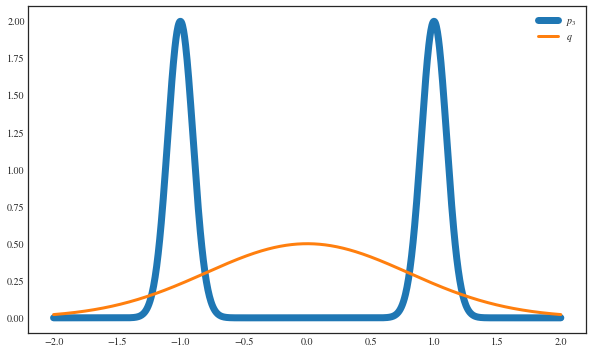

In [18]:
xx = torch.linspace(-2,2,1000).unsqueeze(1)
plt.plot(xx, p_4.log_prob(xx).exp(), label='$p_3$', linewidth=7)
plt.plot(xx, q_4.log_prob(xx).exp(), label='$q$', linewidth=3)
plt.legend()
plt.show()

## Defining Sequences

In [19]:
from steintorch.distribution.base import Distribution

def scale_sequence(u, target_dist, dim=1, bracket=[-3,3], n_mesh=40, use_log_prob=True):
    Q_n = Distribution()

    location, scale = u

    if dim > 1:
        location = torch.zeros(dim) #+ u[0]
        location[0] = u[0]
        scale = torch.ones(dim) #* u[1]
        scale[0] = u[1]

    def sample_Q_n(n):
        return target_dist.sample(n) * scale + location

    def log_prob_Q_n(x):
        return target_dist.log_prob( (x-location) / scale) - torch.log(scale).sum()

    def cdf_Q_n(x):
        return target_dist.cdf((x-location) / scale)

    Q_n.sample = sample_Q_n
    Q_n.log_prob = log_prob_Q_n
    Q_n.cdf = cdf_Q_n
    
    if dim == 1:
        if use_log_prob is True:
            icdf_Q_n = get_icdf(cdf_Q_n, log_prob=log_prob_Q_n, bracket=bracket, n_mesh=n_mesh)
        else:
            icdf_Q_n = get_icdf(cdf_Q_n, bracket=bracket, n_mesh=n_mesh)

        Q_n.icdf = icdf_Q_n

    return Q_n

def phi_increasing_scale(n):
    return torch.Tensor([0,1 - 1 / (n+1.9)])

def phi_decreasing_scale(n):
    return torch.Tensor([0,1 + 2 / (n+1)])

def phi_mix(n):
    return torch.Tensor([max(1 - 1 / 200 * (n ** 1.2), 0), 1 - 1 / (n+1.8) ** 1.2])

converging_sequences = [phi_increasing_scale, phi_decreasing_scale, phi_mix]

def phi_increasing_scale1(n):
    return torch.Tensor([0,1 - 1 / (n+1.9)])

def phi_decreasing_scale1(n):
    return torch.Tensor([0,1 + 2 / (n+1)])

def phi_mix1(n):
    return torch.Tensor([-5 / (n + 4) ** 1.5,1 + 2 / (n+1) ** 1.5 + torch.sin(torch.Tensor([n])) * 1/(n+1) ** 1.5])


converging_sequences = [phi_increasing_scale, phi_decreasing_scale, phi_mix]
converging_sequences_p1 = [phi_increasing_scale1, phi_decreasing_scale1, phi_mix1]


In [20]:
qqtets = scale_sequence(torch.Tensor([2,0.5]), p_3_2d, dim=2)

### Plotting Sequences

In [21]:
N = 100
cm_lin_space = np.linspace(0, 1, N) ** 0.2

def make_Ramp( ramp_colors ): 
    from colour import Color
    from matplotlib.colors import LinearSegmentedColormap
    N = 100
    cm_lin_space = np.linspace(0, 1, N) ** 0.2

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [ Color( c1 ).rgb for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    # plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.1)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.imshow( [list(cm_lin_space * len(ramp_colors))], interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

cm_lin_space = np.linspace(0, 1, N) ** 0.2

good_ramp1 = make_Ramp( ['#19040F','#FF2D96' ] ) 
good_ramp2 =  make_Ramp( ['#191100','#FFB000' ] ) 
good_ramp3 = make_Ramp( ['#0A0E19','#648FFF' ] ) 

good_ramps = [good_ramp1, good_ramp2, good_ramp3]

#### Plotting $P_1$ sequences:

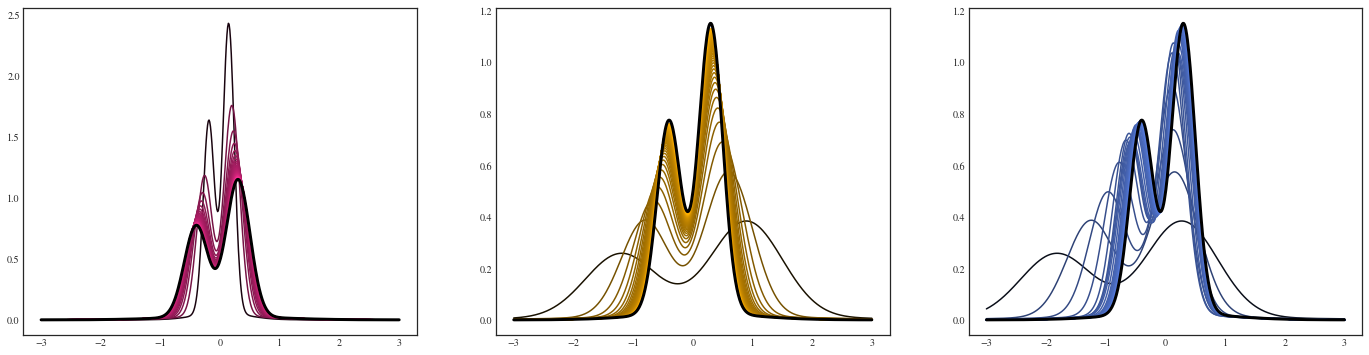

In [22]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(24, 6)

xx = torch.linspace(-3,3,500)

for i in range(N):
    seq1_i = scale_sequence(phi_increasing_scale1(i), p_1)
    seq2_i = scale_sequence(phi_decreasing_scale1(i), p_1)
    seq3_i = scale_sequence(phi_mix1(i), p_1)

    axes[0].plot(xx, seq1_i.log_prob(xx.unsqueeze(1)).exp(), color=good_ramps[0](cm_lin_space[i]))
    axes[1].plot(xx, seq2_i.log_prob(xx.unsqueeze(1)).exp(), color=good_ramps[1](cm_lin_space[i]))
    axes[2].plot(xx, seq3_i.log_prob(xx.unsqueeze(1)).exp(), color=good_ramps[2](cm_lin_space[i]))

axes[0].plot(xx, p_1.log_prob(xx.unsqueeze(1)).exp(), color='black', linewidth=3)
axes[1].plot(xx, p_1.log_prob(xx.unsqueeze(1)).exp(), color='black', linewidth=3)
axes[2].plot(xx, p_1.log_prob(xx.unsqueeze(1)).exp(), color='black', linewidth=3)

#### Plotting $P_2$ sequences:

In [23]:
def phi_increasing_scale(n):
    return torch.Tensor([0,1 - 1 / (n+1.9)])

def phi_decreasing_scale(n):
    return torch.Tensor([0,1 + 2 / (n+1)])

def phi_mix(n):
    return torch.Tensor([max(1.2 - 1 / 200 * (n ** 1.5), 0), (1 - (100 - n)**2/10000) * 2/3 + 1/3])


def phi_increasing_scale1(n):
    return torch.Tensor([0,1 - 1 / (n+1.9)])

def phi_decreasing_scale1(n):
    return torch.Tensor([0,1 + 2 / (n+1)])

def phi_mix1(n):
    return torch.Tensor([-5 / (n + 4) ** 1.5,1 + 2 / (n+1) ** 1.5 + torch.sin(torch.Tensor([n])) * 1/(n+1) ** 1.5])


converging_sequences = [phi_increasing_scale, phi_decreasing_scale, phi_mix]
converging_sequences_p1 = [phi_increasing_scale1, phi_decreasing_scale1, phi_mix1]

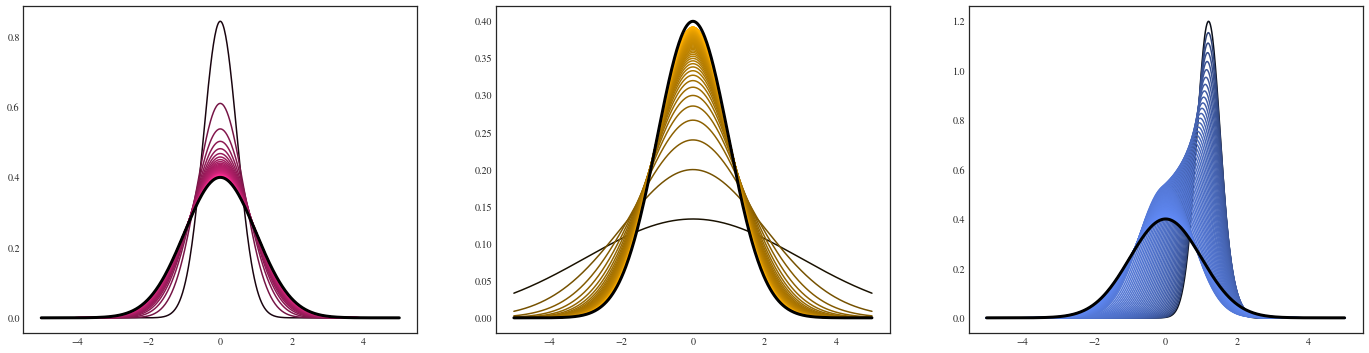

In [24]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(24, 6)
N = 100
xx = torch.linspace(-5,5,500)

for i in range(N):
    seq1_i = scale_sequence(phi_increasing_scale(i), p_2)
    seq2_i = scale_sequence(phi_decreasing_scale(i), p_2)
    seq3_i = scale_sequence(phi_mix(i), p_2)

    axes[0].plot(xx, seq1_i.log_prob(xx).exp(), color=good_ramps[0](cm_lin_space[i]))
    axes[1].plot(xx, seq2_i.log_prob(xx).exp(), color=good_ramps[1](cm_lin_space[i]))
    axes[2].plot(xx, seq3_i.log_prob(xx).exp(), color=good_ramps[2](cm_lin_space[i]))

axes[0].plot(xx, p_2.log_prob(xx).exp(), color='black', linewidth=3)
axes[1].plot(xx, p_2.log_prob(xx).exp(), color='black', linewidth=3)
axes[2].plot(xx, p_2.log_prob(xx).exp(), color='black', linewidth=3)

#### Plotting $P_3$ sequences:

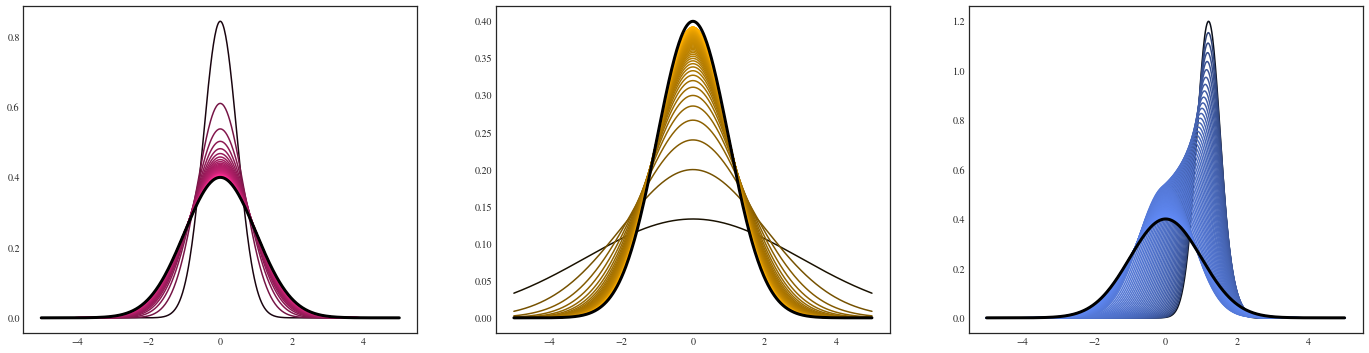

In [25]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(24, 6)

xx = torch.linspace(-5,5,500).unsqueeze(1)

for i in range(N):
    seq1_i = scale_sequence(phi_increasing_scale(i), p_3_1d)
    seq2_i = scale_sequence(phi_decreasing_scale(i), p_3_1d)
    seq3_i = scale_sequence(phi_mix(i), p_3_1d)

    axes[0].plot(xx, seq1_i.log_prob(xx).exp(), color=good_ramps[0](cm_lin_space[i]))
    axes[1].plot(xx, seq2_i.log_prob(xx).exp(), color=good_ramps[1](cm_lin_space[i]))
    axes[2].plot(xx, seq3_i.log_prob(xx).exp(), color=good_ramps[2](cm_lin_space[i]))

axes[0].plot(xx, p_3_1d.log_prob(xx).exp(), color='black', linewidth=3)
axes[1].plot(xx, p_3_1d.log_prob(xx).exp(), color='black', linewidth=3)
axes[2].plot(xx, p_3_1d.log_prob(xx).exp(), color='black', linewidth=3)

#### Plotting $P_4$ sequences:

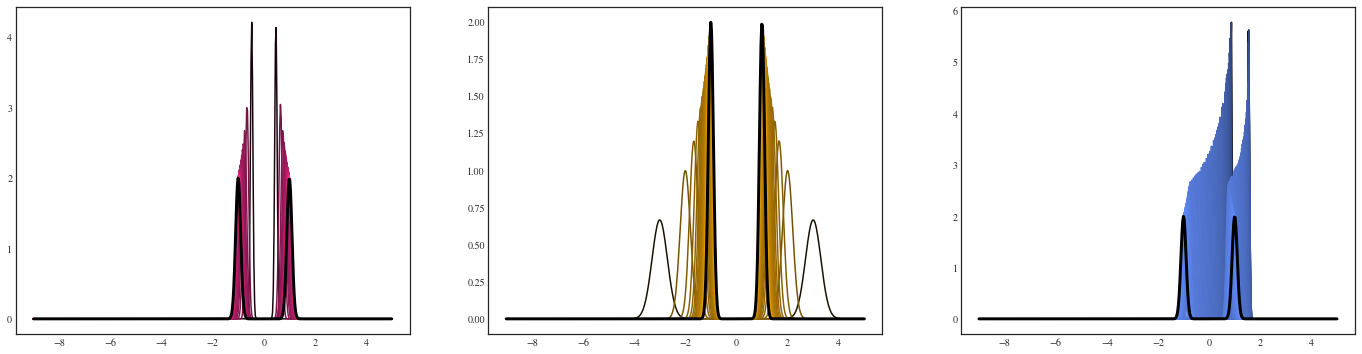

In [26]:
fig, axes = plt.subplots(1,3)
fig.set_size_inches(24, 6)

xx = torch.linspace(-9,5,500).unsqueeze(1)

for i in range(N):
    seq1_i = scale_sequence(phi_increasing_scale(i), p_4)
    seq2_i = scale_sequence(phi_decreasing_scale(i), p_4)
    seq3_i = scale_sequence(phi_mix(i), p_4)

    axes[0].plot(xx, seq1_i.log_prob(xx).exp(), color=good_ramps[0](cm_lin_space[i]))
    axes[1].plot(xx, seq2_i.log_prob(xx).exp(), color=good_ramps[1](cm_lin_space[i]))
    axes[2].plot(xx, seq3_i.log_prob(xx).exp(), color=good_ramps[2](cm_lin_space[i]))

axes[0].plot(xx, p_4.log_prob(xx).exp(), color='black', linewidth=3)
axes[1].plot(xx, p_4.log_prob(xx).exp(), color='black', linewidth=3)
axes[2].plot(xx, p_4.log_prob(xx).exp(), color='black', linewidth=3)

## Plotting Convergence

In [27]:
from steintorch.divergence.ksd import GradientFreeKSD

gf_KSD = GradientFreeKSD(None)

In [28]:
M = 200 # mesh size
N = 100 # sequence length

uniform_mesh = torch.linspace(0, 1, M + 2)[1:-1]

In [30]:
p1_icdf = get_icdf(p_1.cdf, p_1.log_prob)
p1_uniform_mesh = torch.Tensor(p1_icdf(uniform_mesh)).unsqueeze(1)

p4_icdf = get_icdf(p_4.cdf, p_4.log_prob)
p4_uniform_mesh = torch.Tensor(p4_icdf(uniform_mesh)).unsqueeze(1)

/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:466: RuntimeWarning: some failed to converge after 200 iterations
  warnings.warn(msg, RuntimeWarning)
/Users/matthewfisher/dev/pytorch/.direnv/python-3.9.7/lib/python3.9/site-packages/scipy/optimize/_zeros_py.py:458: RuntimeWarning: some derivatives were zero
  warnings.warn(msg, RuntimeWarning)


In [31]:
ksd_p1 = [[] for i in range(3)] 
ksd_p2 = [[] for i in range(3)] 
ksd_p3_dim1 = [[] for i in range(3)] 
ksd_p3_dim10 = [[] for i in range(3)] 
ksd_p3_dim100 = [[] for i in range(3)] 
ksd_p4 = [[] for i in range(3)] 
ksd_p4bad = [[] for i in range(3)] 

sobol_1d = torch.Tensor(Sobol(1, seed=2).random_base2(10))
sobol_10d = torch.Tensor(Sobol(10, seed=2).random_base2(10))
sobol_100d = torch.Tensor(Sobol(100, seed=2).random_base2(10))

for j in range(3):
    for i in range(N):
        Q_ij_p1 = scale_sequence(converging_sequences[j](i), target_dist=p_1)
        Q_ij_p2 = scale_sequence(converging_sequences[j](i), target_dist=p_2)
        Q_ij_p3_1d = scale_sequence(converging_sequences[j](i), target_dist=p_3_1d)
        Q_ij_p3_10d = scale_sequence(converging_sequences[j](i), target_dist=p_3_10d, dim=10)
        Q_ij_p3_100d = scale_sequence(converging_sequences[j](i), target_dist=p_3_100d, dim=100)
        Q_ij_p4 = scale_sequence(converging_sequences[j](i), target_dist=p_4)
        Q_ij_p4bad = scale_sequence(converging_sequences[j](i), target_dist=p_4_bad)

        location, scale = converging_sequences[j](i)

        Q_ij_p1_sample = (p1_uniform_mesh * scale + location).requires_grad_(True)
        Q_ij_p2_sample = torch.Tensor(Q_ij_p2.icdf(uniform_mesh)).unsqueeze(1).requires_grad_(True)
        Q_ij_p3_1d_sample = get_uniform_sequence(sobol_1d, u=converging_sequences[j](i)).requires_grad_(True)
        Q_ij_p3_10d_sample = get_uniform_sequence(sobol_10d, u=converging_sequences[j](i)).requires_grad_(True)
        Q_ij_p3_100d_sample = get_uniform_sequence(sobol_100d, u=converging_sequences[j](i)).requires_grad_(True)
        Q_ij_p4_sample = (p4_uniform_mesh * scale + location).requires_grad_(True)
        Q_ij_p4bad_sample = torch.Tensor(Q_ij_p4bad.icdf(uniform_mesh)).unsqueeze(1).requires_grad_(True)
    
        ksd_p1[j].append(gf_KSD.eval(Q_ij_p1_sample, p_1.log_prob, q_1.log_prob, score_q_1).detach())
        ksd_p2[j].append(gf_KSD.eval(Q_ij_p2_sample, p_2.log_prob, q_2.log_prob, score_q_2).detach())
        ksd_p3_dim1[j].append(gf_KSD.eval(Q_ij_p3_1d_sample, p_3_1d.log_prob, q_3_1d.log_prob, score_q_3_1d).detach())
        ksd_p3_dim10[j].append(gf_KSD.eval(Q_ij_p3_10d_sample, p_3_10d.log_prob, q_3_10d.log_prob, score_q_3_10d).detach())
        ksd_p3_dim100[j].append(gf_KSD.eval(Q_ij_p3_100d_sample, p_3_100d.log_prob, q_3_100d.log_prob, score_q_3_100d).detach())
        ksd_p4[j].append(gf_KSD.eval(Q_ij_p4_sample, p_4.log_prob, q_4.log_prob, score_q_4).detach())
        ksd_p4bad[j].append(gf_KSD.eval(Q_ij_p4bad_sample, p_4.log_prob, q_4.log_prob, score_q_4).detach())



C:\Users\matth\AppData\Local\Temp/ipykernel_14588/2859062172.py:81: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\matth\AppData\Local\Temp/ipykernel_14588/2859062172.py:83: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("figure_2.pdf", bbox_inches = "tight", padding = 0)


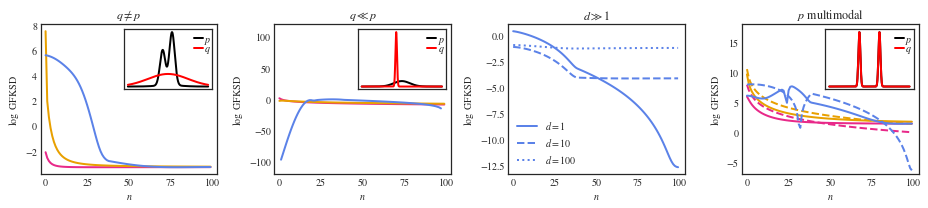

In [163]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1,4)
fig.set_size_inches(13, 3)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2

value_col = .9
colors = []

i = 2
axes[2].plot(XX, torch.Tensor(ksd_p3_dim1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), label="$d=1$")
axes[2].plot(XX, torch.Tensor(ksd_p3_dim10[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls = '--', label="$d=10$")
axes[2].plot(XX, torch.Tensor(ksd_p3_dim100[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls = 'dotted', label="$d=100$")
axes[2].legend(loc=3)

for i in range(3):
    axes[0].plot(XX, torch.Tensor(ksd_p1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[1].plot(XX, torch.Tensor(ksd_p2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))


    axes[3].plot(XX, torch.Tensor(ksd_p4[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[3].plot(XX, torch.Tensor(ksd_p4bad[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls='--')

# axes[0].set_title("$q=$Prior")

LIN = torch.linspace(-2,2,500)

for i in range(4):
    axes[i].set_xlabel("$n$")
    axes[i].set_xlim(-3,103)

axes[3].set_ylim(-7,18)
axes[1].set_ylim(-120,120)


axes[0].set_ylabel("$\log$ GFKSD")
axes[1].set_ylabel("$\log$ GFKSD")
axes[2].set_ylabel("$\log$ GFKSD")
axes[3].set_ylabel("$\log$ GFKSD")


axes[0].set_title('$q \ p$')
axes[1].set_title('$q \ll p$')
axes[2].set_title('$d \gg 1$')
axes[3].set_title('$p$ multimodal')

# inset axes:

inset_width = '50%'
inset_height = '40%'
axins1 = inset_axes(axes[0], width=inset_width, height=inset_height, loc=1) #p_1
axins1.plot(LIN, p_1.log_prob(torch.linspace(-3,3,500).unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
axins1.plot(LIN, q_1.log_prob(torch.linspace(-3,3,500).unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
axins1.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

axins2 = inset_axes(axes[1], width=inset_width, height=inset_height, loc=1) #laplace
axins2.plot(LIN, p_2.log_prob(torch.linspace(-5,5,500).unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins2.plot(LIN, q_2.log_prob(torch.linspace(-5,5,500).unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins2.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

LIN2 = torch.linspace(-4,4,500)
axins4 = inset_axes(axes[3], width=inset_width, height=inset_height, loc=1) #KDE
axins4.plot(LIN2, p_4.log_prob(LIN2.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins4.plot(LIN2, q_4.log_prob(LIN2.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label="$q$", color="red")
axins4.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

for axi in [axins1, axins2, axins4]:
    axi.tick_params(labelleft=False, labelbottom=False)

fig.tight_layout()

# fig.savefig("figure_2.pdf", bbox_inches = "tight", padding = 0)
plt.show()


/var/folders/y9/f2jq2rkn6h16kl4g9j02c2800000gn/T/ipykernel_2967/2234431257.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


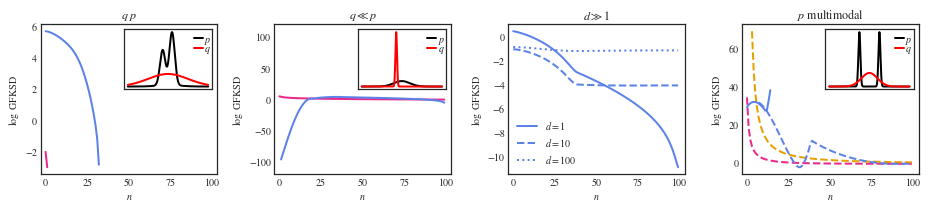

In [33]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1,4)
fig.set_size_inches(13, 3)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2

value_col = .9
colors = []

i = 2
axes[2].plot(XX, torch.Tensor(ksd_p3_dim1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), label="$d=1$")
axes[2].plot(XX, torch.Tensor(ksd_p3_dim10[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls = '--', label="$d=10$")
axes[2].plot(XX, torch.Tensor(ksd_p3_dim100[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls = 'dotted', label="$d=100$")
axes[2].legend(loc=3)

for i in range(3):
    axes[0].plot(XX, torch.Tensor(ksd_p1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[1].plot(XX, torch.Tensor(ksd_p2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[3].plot(XX, torch.Tensor(ksd_p4[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes[3].plot(XX, torch.Tensor(ksd_p4bad[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls='--')

# axes[0].set_title("$q=$Prior")

LIN = torch.linspace(-2,2,500)

for i in range(4):
    axes[i].set_xlabel("$n$")
    axes[i].set_xlim(-3,103)

axes[3].set_ylim(-7,18)
axes[1].set_ylim(-120,120)


axes[0].set_ylabel("$\log$ GFKSD")
axes[1].set_ylabel("$\log$ GFKSD")
axes[2].set_ylabel("$\log$ GFKSD")
axes[3].set_ylabel("$\log$ GFKSD")


axes[0].set_title('$q \ p$')
axes[1].set_title('$q \ll p$')
axes[2].set_title('$d \gg 1$')
axes[3].set_title('$p$ multimodal')

# inset axes:

inset_width = '50%'
inset_height = '40%'
axins1 = inset_axes(axes[0], width=inset_width, height=inset_height, loc=1) #p_1
axins1.plot(LIN, p_1.log_prob(torch.linspace(-3,3,500).unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
axins1.plot(LIN, q_1.log_prob(torch.linspace(-3,3,500).unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
axins1.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

axins2 = inset_axes(axes[1], width=inset_width, height=inset_height, loc=1) #laplace
axins2.plot(LIN, p_2.log_prob(torch.linspace(-5,5,500).unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins2.plot(LIN, q_2.log_prob(torch.linspace(-5,5,500).unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins2.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

LIN2 = torch.linspace(-4,4,500)
axins4 = inset_axes(axes[3], width=inset_width, height=inset_height, loc=1) #KDE
axins4.plot(LIN2, p_4.log_prob(LIN2.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins4.plot(LIN2, q_4.log_prob(LIN2.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label="$q$", color="red")
axins4.legend(loc=1, bbox_to_anchor=(1.095,1.07), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)

for axi in [axins1, axins2, axins4]:
    axi.tick_params(labelleft=False, labelbottom=False)

fig.tight_layout()

# fig.savefig("figure_2.pdf", bbox_inches = "tight", padding = 0)
plt.show()


C:\Users\matth\AppData\Local\Temp/ipykernel_14588/3361534820.py:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\matth\AppData\Local\Temp/ipykernel_14588/3361534820.py:42: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("figure_2d.pdf", bbox_inches = "tight", padding = 0)


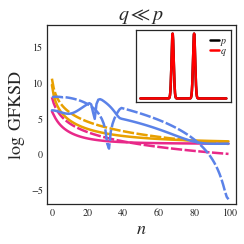

In [219]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1,1)
fig.set_size_inches(3.5, 3.5)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2.5

value_col = .9
colors = []


for i in range(3):
    axes.plot(XX, torch.Tensor(ksd_p4[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))
    axes.plot(XX, torch.Tensor(ksd_p4bad[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls='--',  dashes=[4.5, 1])

LIN = torch.linspace(-2,2,500)

axes.set_ylim(-7,18)

axes.set_ylabel("$\log$ GFKSD", fontsize=18)
axes.set_title('$q \ll p$', fontsize=20)
axes.set_xlabel("$n$", fontsize=18)
axes.set_xlim(-3,103)

# inset axes:
inset_width = '50%'
inset_height = '40%'
axins4 = inset_axes(axes, width=inset_width, height=inset_height, loc=1) #KDE
axins4.plot(LIN2, p_4.log_prob(LIN2.unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins4.plot(LIN2, q_4.log_prob(LIN2.unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label="$q$", color="red")
axins4.legend(loc=1, bbox_to_anchor=(1.065,1.05), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins4.tick_params(labelleft=False, labelbottom=False)

fig.tight_layout()

fig.savefig("figure_2d.pdf", bbox_inches = "tight", padding = 0)


plt.show()


C:\Users\matth\AppData\Local\Temp/ipykernel_14588/3196395227.py:33: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("figure_2c.pdf", bbox_inches = "tight", padding = 0)


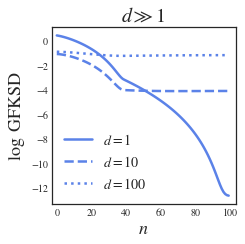

In [211]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1,1)
fig.set_size_inches(3.5, 3.5)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2.5

value_col = .9
colors = []


i = 2
axes.plot(XX, torch.Tensor(ksd_p3_dim1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), label="$d=1$")
axes.plot(XX, torch.Tensor(ksd_p3_dim10[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls = '--', label="$d=10$")
axes.plot(XX, torch.Tensor(ksd_p3_dim100[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col), ls = 'dotted', label="$d=100$")
axes.legend(loc=3, fontsize=14)


axes.set_ylabel("$\log$ GFKSD", fontsize=18)
axes.set_title('$d \gg 1$', fontsize=20)
axes.set_xlabel("$n$", fontsize=18)
axes.set_xlim(-3,103)

# inset axes:


fig.tight_layout()

fig.savefig("figure_2c.pdf", bbox_inches = "tight", padding = 0)


plt.show()


C:\Users\matth\AppData\Local\Temp/ipykernel_14588/2704122120.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\matth\AppData\Local\Temp/ipykernel_14588/2704122120.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("figure_2b.pdf", bbox_inches = "tight", padding = 0)


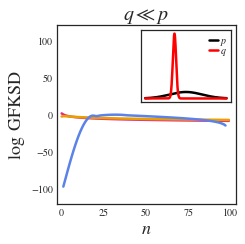

In [212]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1,1)
fig.set_size_inches(3.5, 3.5)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2.5

value_col = .9
colors = []


for i in range(3):
    axes.plot(XX, torch.Tensor(ksd_p2[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))

LIN = torch.linspace(-2,2,500)


axes.set_ylabel("$\log$ GFKSD", fontsize=18)
axes.set_title('$q \ll p$', fontsize=20)
axes.set_xlabel("$n$", fontsize=18)
axes.set_xlim(-3,103)
axes.set_ylim(-120,120)

# inset axes:
inset_width = '50%'
inset_height = '40%'
axins2 = inset_axes(axes, width=inset_width, height=inset_height, loc=1) #laplace
axins2.plot(LIN, p_2.log_prob(torch.linspace(-2.5,2.5,500).unsqueeze(-1)).exp(), linewidth=THICKNESS,  label = '$p$', color="black")
axins2.plot(LIN, q_2.log_prob(torch.linspace(-2.5,2.5,500).unsqueeze(-1)).exp(), linewidth=THICKNESS, label="$q$", color="red")
axins2.legend(loc=1, bbox_to_anchor=(1.065,1.05), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins2.tick_params(labelleft=False, labelbottom=False)

fig.tight_layout()

fig.savefig("figure_2b.pdf", bbox_inches = "tight", padding = 0)


plt.show()


C:\Users\matth\AppData\Local\Temp/ipykernel_14588/721959874.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()
C:\Users\matth\AppData\Local\Temp/ipykernel_14588/721959874.py:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "padding" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig("figure_2a.pdf", bbox_inches = "tight", padding = 0)


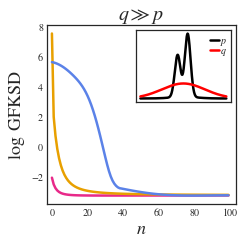

In [213]:
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(1,1)
fig.set_size_inches(3.5, 3.5)

min_y, max_y = -8, 8
XX = torch.Tensor([j for j in range(N)])
plot_y_range = False
THICKNESS = 2.5

value_col = .9
colors = []


for i in range(3):
    axes.plot(XX, torch.Tensor(ksd_p1[i]).detach().log(), linewidth=THICKNESS, color=good_ramps[i](value_col))


LIN = torch.linspace(-2,2,500)


axes.set_ylabel("$\log$ GFKSD", fontsize=18)
axes.set_title('$q \gg p$', fontsize=20)
axes.set_xlabel("$n$", fontsize=18)
axes.set_xlim(-3,103)
# inset axes:

inset_width = '50%'
inset_height = '40%'
axins1 = inset_axes(axes, width=inset_width, height=inset_height, loc=1) #p_1
axins1.plot(LIN, p_1.log_prob(torch.linspace(-3,3,500).unsqueeze(-1)).exp(), linewidth=THICKNESS, label = '$p$', color="black")
axins1.plot(LIN, q_1.log_prob(torch.linspace(-3,3,500).unsqueeze(-1)).exp().detach(), linewidth=THICKNESS, label='$q$', color="red")
axins1.legend(loc=1, bbox_to_anchor=(1.065,1.05), fontsize=10, labelspacing=-0.2, handlelength=0.9, handletextpad=0.15)


axins1.tick_params(labelleft=False, labelbottom=False)

fig.tight_layout()

fig.savefig("figure_2a.pdf", bbox_inches = "tight", padding = 0)



plt.show()


#### Plotting Location-Scale Sequence: